In [7]:
!pip install pyvista
!pip install matplotlib

In [8]:
import dolfinx
import numpy as np
from mpi4py import MPI
from dolfinx.cpp.mesh import CellType
import pyvista
import dolfinx.plot
from math import sin, cos, pi

In [23]:
W = 40 # in mm
L = 90 # in mm
E =  5e2 # in mPa
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
mu = E/(2*(1+nu))
lambda_ = E*nu/((1+nu)*(1-2*nu))

In [24]:
mesh = dolfinx.BoxMesh(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])], [20,6,6], cell_type=CellType.hexahedron)
V = dolfinx.VectorFunctionSpace(mesh, ("CG", 1))

In [25]:
# Activate framebuffer, required for visualziation
pyvista.start_xvfb(wait=0.05)
# Create background plotter and mesh to attach values to
def plot_function(mesh, t, uh):
    topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
    
    p = pyvista.Plotter(window_size=[960,480])
    # Add time-stamp
    p.add_text(f"Time: {t}", font_size=12, name="timelabel")
    p.add_text("Deformed configuration", name="title", position="upper_edge")
   
    # Update point values on pyvista grid
    topology, cell_types = dolfinx.plot.create_vtk_topology(V)
     # We create a geometry for our modified mesh using the dof coordinates
    geometry = V.tabulate_dof_coordinates()
    # As we are dealing with a vector field, we reshape the underlying dof array to accommedate for the three dimensional space
    num_dofs = V.dofmap.index_map.size_local + V.dofmap.index_map.num_ghosts
    values = np.zeros((num_dofs, 3), dtype=np.float64)
    values[:, :mesh.geometry.dim] = uh.x.array.real.reshape(num_dofs, V.dofmap.index_map_bs)

    # Create grid defined by the function space for visualization
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    function_grid["u"] = values
    function_grid.set_active_vectors("u")
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector("u", factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)

In [26]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, clamped_boundary)

u_D = dolfinx.Function(V)
with u_D.vector.localForm() as loc:
    loc.set(0)
bc = dolfinx.DirichletBC(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

In [27]:
T = dolfinx.Constant(mesh, (0, 0, 0))

In [28]:
import ufl
ds = ufl.Measure("ds", domain=mesh)

In [29]:
beam_angle = 90
beam_angle *= pi/180

In [30]:
def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = dolfinx.Constant(mesh, (rho*g*cos(beam_angle), 0, -rho*g*sin(beam_angle)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

In [31]:
problem = dolfinx.fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

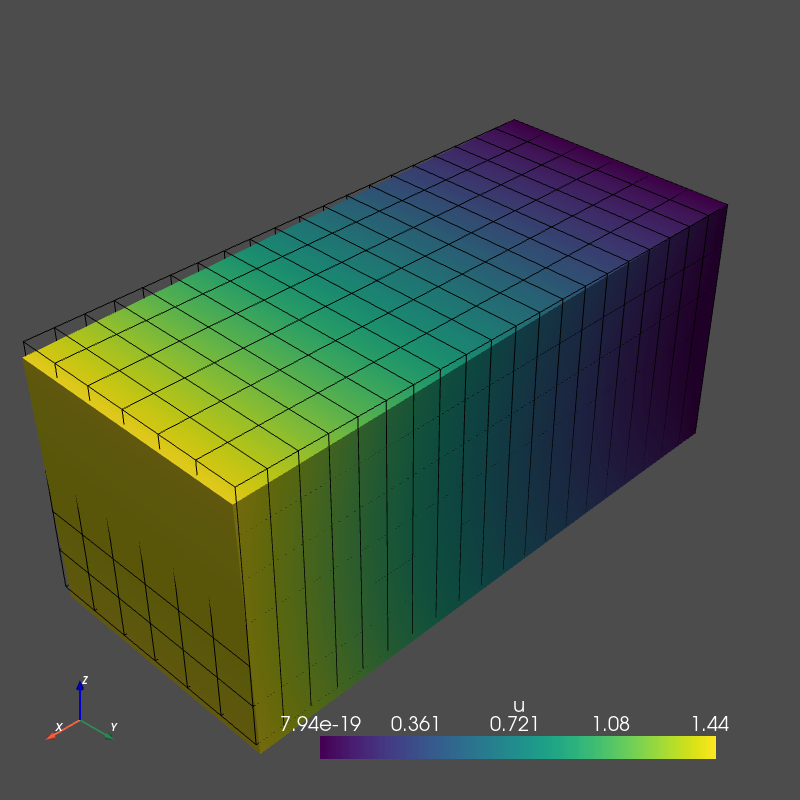

In [34]:
# Start xvfb for rendering plots
pyvista.start_xvfb(wait=0.05)

# Create plotter and pyvista grid
p = pyvista.Plotter(title="Deflection", window_size=[800, 800], notebook=True)
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.compute_point_values().real 
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
    figure_as_array = p.screenshot("deflection.png")